In [1]:
import cv2

In [8]:
import matlab
import matlab.engine as me

import numpy as np
from numpy import linalg as linalg
import scipy.interpolate as interp
from skimage import io

import scipy.ndimage as ndi
from scipy.ndimage._ni_support import _normalize_sequence


In [9]:
import matplotlib

from matplotlib import colors, ticker, gridspec, rc, transforms
from matplotlib.ticker import PercentFormatter, LogFormatter, FuncFormatter, LogLocator, AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter, OrderedDict

import os
from importlib import reload

import myfun as mf

# setup matplotlib latex use
#matplotlib.use('agg')
rc('text',usetex=True)
rc('text.latex', preamble=r'\usepackage{color}')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'


matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

import matplotlib.pyplot as plt
#from wordcloud import WordCloud
import time



In [10]:
import zhang_suen.thinning as thinner
#from cv2_rolling_ball import subtract_background_rolling_ball
from skimage import io
import thinning as GH

In [12]:
# functions...
def get_rowmap(cldistIdxs):
    rowmap = [[] for i in range(np.max(cldistIdxs)+1)]
    for i in range(cldistIdxs.shape[0]):
            rowmap[cldistIdxs[i]].append(i)
    return rowmap

def coords(cldistIdxs, cldists, bI,dI):
   
    rowmap = get_rowmap(cldistIdxs)

    coords = [np.vstack([i*np.ones(len(rowmap[i])),
                         cldists[rowmap[i]],
                         bI[rowmap[i]],
                         dI[rowmap[i]],
                         np.divide(bI[rowmap[i]], dI[rowmap[i]], out=np.zeros(len(rowmap[i])),where=dI[rowmap[i]]!=0)
                                   ]).T for i in range(len(rowmap1))]

    coordsf  = np.array(mf.flatten2d(coords))
    idxs     = np.where(np.isfinite(np.sum(coordsf, axis=1)))[0]
    
    return coordsf[idxs]

def mu_err(dat, ax = 1):
    
    mus = np.nanmean(dat,axis=ax)
    mx  = np.nanmax(mus)
    mus = mus/mx
    errs = np.nanstd(dat/mx,axis=ax)/np.sqrt(np.sum(np.isfinite(dat),axis=ax))
    
    return mus, errs

def get_perpline(xs,ys):
    m,b      = np.polyfit(xs, ys, 1)
    xc       = np.mean(xs)
    yc       = np.mean(ys)
    return lambda x: -1./m*(x-xc)+yc 

def cm_and_moi(mask, sumdI, surfMat):
    
    # center of mass 
    nrow,ncol = mask.shape
    xs        = np.array([np.arange(ncol) for i in range(nrow)]);
    ys        = np.array([np.arange(nrow) for i in range(ncol)]).T;

    ms        = sumdI*mask;
    zs        = surfMat*mask;

    totM      = np.sum(ms)
    cm        = [np.sum(ms*xs),np.sum(ms*ys),np.sum(ms*zs)]/totM;
    
    # moment of inertia
    xsc = xs-cm[0]
    ysc = ys-cm[1]
    zsc = zs-cm[2]

    xssq = xsc**2;
    yssq = ysc**2;
    zssq = zsc**2;

    moixx = np.sum(ms*(yssq + zssq));
    moiyy = np.sum(ms*(xssq + zssq));
    moizz = np.sum(ms*(xssq + yssq));
    moixy = np.sum(-ms*xsc*ysc);
    moixz = np.sum(-ms*xsc*zsc);
    moiyz = np.sum(-ms*ysc*zsc);

    moi = np.array([[moixx, moixy, moixz], [moixy,moiyy,moiyz], [moixz, moiyz, moizz]]);
    
    lams,vs  = np.linalg.eig(moi)
    #v1,v2,v3 = vs.T
    lens     = np.sqrt(3*lams/totM); #np.sqrt(lams) #np.sqrt(lams)
    
    return cm, vs.T, lens

def getdist(u, du, met):
    gc00 = met[0,0,u[:,1],u[:,0]]
    gc01 = met[0,1,u[:,1],u[:,0]]
    gc10 = met[1,0,u[:,1],u[:,0]]
    gc11 = met[1,1,u[:,1],u[:,0]]

    dlsq = du[:,0]*(gc00*du[:,0]+gc01*du[:,1]) + du[:,1]*(gc10*du[:,0]+gc11*du[:,1])
    return np.sum(np.sqrt(dlsq)) #np.sqrt(np.sum(dlsq))

def get_all_dists_from_pt(src, trgs, met, stepsz):
    
    # round input to integers
    srci    = np.array(np.around(src[0:2]),dtype='int')
    trgsi   = np.array(np.around(trgs[:,0:2]),dtype='int')
    
    curves  = np.array(np.dstack([srci*np.ones((trgsi.shape[0],2)),trgsi]).transpose((0,2,1)),dtype='int')
    dcurves = np.dstack([np.zeros((trgsi.shape[0],2)),srci-trgsi]).transpose((0,2,1))*stepsz
    
    return np.array([getdist(curves[i], dcurves[i], met) for i in range(curves.shape[0])])    

def surfaceDists(srcs, targs, met, stepSize = [1,1]):
    
    # targs.shape = N x 2  
    # srcs.shape  = M x 2  -- 
    # FOR BOTH MATRICES ensure that: 1st column is row indexes, second column is column indexes
    
    # points on surface (as integers, because needed for indexing)
    us      = np.array(np.around(targs),dtype='int') # N x 2 
    surfmet = met[:,:,us[:,0],us[:,1]] # 2 x 2 x N
    
    # cartesian distance between all surface points and all centerline points
    dusijx = np.subtract.outer(srcs[:,0],targs[:,0]) * stepSize[0] # M x N
    dusijy = np.subtract.outer(srcs[:,1],targs[:,1]) * stepSize[1] # M x N

    
    # metric distance between them
    dlsqds = (dusijx * ( surfmet[0,0] * dusijx + 
                         surfmet[0,1] * dusijy 
                       ) + 
              dusijy * ( surfmet[1,0] * dusijx + 
                         surfmet[1,1] * dusijy
                       )) # M x N

    # minimize over srcs
    closestSrcIdx = np.argmin(dlsqds,axis=0)
    dists         = np.sqrt(np.array([dlsqds[closestSrcIdx[i],i] for i in range(dlsqds.shape[1])]))
    #dists        = np.sqrt(np.nanmin(dlsqds,axis=0))
    
    return dists, closestSrcIdx # N x 1

def get_ml_cs(cspts, col, zstack):
    nz, nrow, ncol = zstack.shape
    csBegs = np.where(cspts[col][:,0]<0)[0]
    csEnds = np.where(cspts[col][:,0]>=nrow)[0]
    csBeg  = np.amax(csBegs, initial=0)
    csEnd  = np.amin(csEnds, initial=ncol)
    return np.hstack([np.zeros((nz,csBeg)), 
                      zstack[:,cspts[col][csBeg:csEnd,0],cspts[col][csBeg:csEnd,1]],
                      np.zeros((nz,ncol-csEnd))])

def pbsDB(nm, nlayers, nrow, ncol):
    
    onion={
    'nLayers':float(nlayers),
    'layerDistance':1.
    }

    # generate the pullback
    eng.workspace["onion"] = onion
    eng.evalc("{0}.SOI.pullbackStack({0}.stack, {0}.currentROI,{0}.currentTime,onion)".format(nm))

    maxlayer  = int((onion['nLayers']-1)/2)
    layerStrs = ['_layer_m{0}'.format(i) for i in range(maxlayer,0,-1)] + [''] +\
    ['_layer_p{0}'.format(i) for i in range(1, maxlayer+1)]

    cmd1f = lambda x : '''data = {0}.SOI.getField('data{1}');'''.format(nm,x)
    cmd1s = list(map(cmd1f,layerStrs))
    cmd2  = '''data = data(1);''' 
    cmd3a = '''data.getPatch('xy_index').getTransform('xy').apply{1}'''
    cmd3b = '''data.getPatch('xy_index').getTransform('xy').apply{2}'''
    cmd3c = '''data.getPatch('xy_index').getTransform('xy').apply{3}'''


    pbsD   = np.zeros((nlayers,nrow,ncol))
    pbsB   = np.zeros((nlayers,nrow,ncol))
    pbsBbs = np.zeros((nlayers,nrow,ncol))


    for i in range(nlayers):
        eng.evalc(cmd1s[i]+cmd2)
        pbsD[i]=np.array(eng.eval(cmd3a))
        pbsB[i]=np.array(eng.eval(cmd3b))
        pbsBbs[i]=np.array(eng.eval(cmd3c))

        
    return pbsD, pbsB, pbsBbs

def fitline(xs,ys, npts):
    cord = np.argsort(xs)
    xsc = xs[cord]
    ysc = ys[cord]
    idxs     = np.where(np.isfinite(ysc))[0][0:npts]
    if len(idxs>2):
        m,b = np.polyfit(xsc[idxs], ysc[idxs], 1)
        return m, b
    else:
        return 0,0

In [13]:
plotdir = '/Users/simonfreedman/cqub/plenaria/plots'

In [16]:
# looking at cross sections
# import the actual z stacks
datdir = '/Users/simonfreedman/cqub/plenaria/data/'
sampname = 'dorsal_7' #'w2_dorsal_14_'
z1d='{0}/BMP4_Tls__Day15_Control_{1}_w301 405.TIF'.format(datdir,sampname)
z1b='{0}/BMP4_Tls__Day15_Control_{1}_w203 Cy3.TIF'.format(datdir,sampname)

im1d = io.imread(z1d)
im1b = io.imread(z1b)

sampname = 'w2_dorsal_14'
z2d='{0}/BMP4_Tls__Day15_Control_{1}_w301 405.TIF'.format(datdir,sampname)
z2b='{0}/BMP4_Tls__Day15_Control_{1}_w203 Cy3.TIF'.format(datdir,sampname)

im2d = io.imread(z2d)
im2b = io.imread(z2b)

In [17]:
# import background subtracted zstack
sampname = 'dorsal_7' #'w2_dorsal_14_'
z1bbs='{0}/BMP4_Tls__Day15_Control_{1}_w203 Cy3_bs.tif'.format(datdir,sampname)
im1bbs = io.imread(z1bbs)

sampname = 'w2_dorsal_14'
z2bbs='{0}/BMP4_Tls__Day15_Control_{1}_w203 Cy3_bs.tif'.format(datdir,sampname)
im2bbs = io.imread(z2bbs)


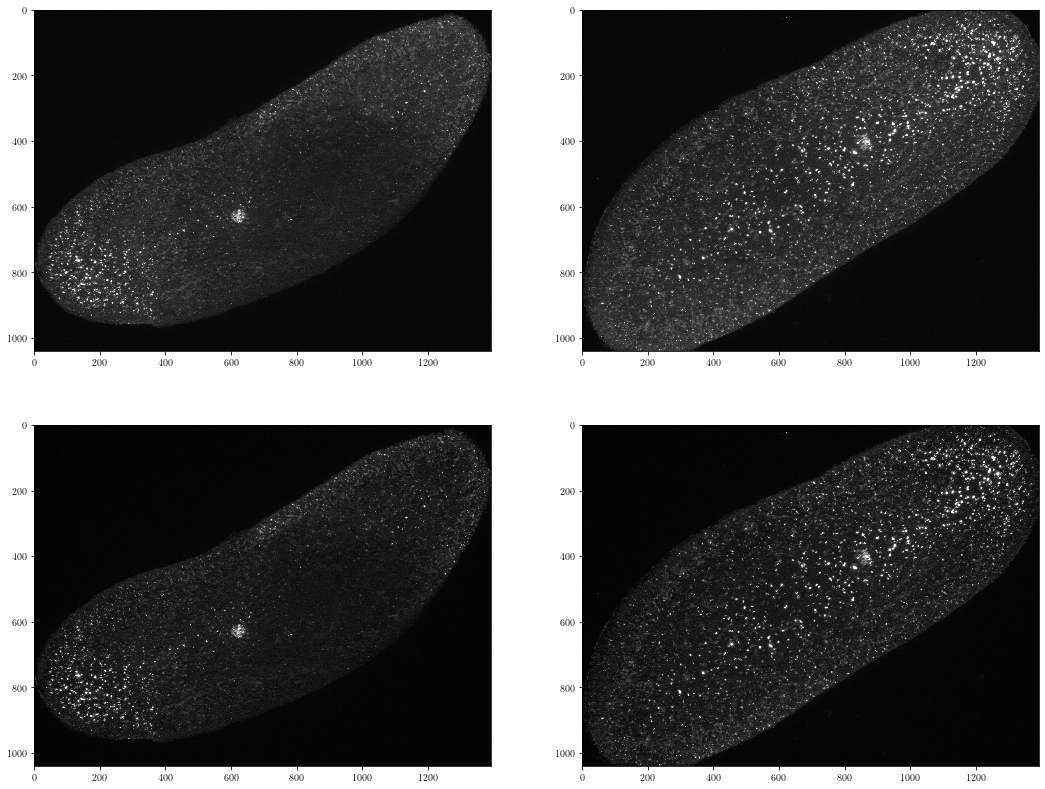

In [18]:
maxproj1b = np.max(im1b,axis=0)
maxproj2b = np.max(im2b,axis=0)

maxproj1bbs = np.max(im1bbs,axis=0)
maxproj2bbs = np.max(im2bbs,axis=0)

maxproj1d = np.max(im1d, axis=0)
maxproj2d = np.max(im2d, axis=0)


fig,axs=plt.subplots(2,2,figsize=(18,14))
axs[0,0].imshow(maxproj1b,vmin=10,vmax=1000,cmap='binary_r')
axs[0,1].imshow(maxproj2b,vmin=10,vmax=1000,cmap='binary_r')

axs[1,0].imshow(maxproj1bbs,vmin=10,vmax=1000,cmap='binary_r')
axs[1,1].imshow(maxproj2bbs,vmin=10,vmax=1000,cmap='binary_r')

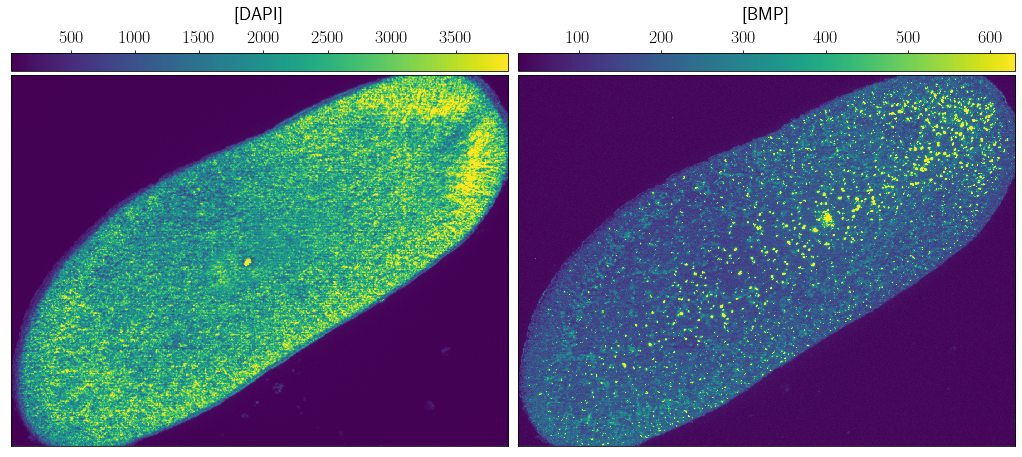

In [21]:
fig,axs=plt.subplots(1,2,figsize=(18,14))
axs[0].imshow(maxproj2d,cmap='binary_r')
axs[1].imshow(maxproj2b,cmap='binary_r')

labs = ['[DAPI]', '[BMP]']
dats = [maxproj2d, maxproj2b]
for i in range(2):
    im1      = axs[i].imshow(dats[i], vmax=np.nanquantile(dats[i],0.99))
    divider  = make_axes_locatable(axs[i])
    cax2     = divider.append_axes("top", size="5%", pad=0.05)
    cbar     = fig.colorbar(im1, cax=cax2, orientation='horizontal')
    cbar.set_label(labs[i],rotation=0, labelpad=10, fontsize=18)
    cax2.xaxis.set_label_position('top')
    cax2.xaxis.set_ticks_position('top')
    cbar.ax.tick_params(labelsize=18)
    
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.subplots_adjust(wspace=0.02)

#plt.savefig('{0}/dapi_bmp_max_proj_14.jpg'.format(plotdir), bbox_inches="tight")

In [26]:
eng = me.start_matlab()

In [27]:
eng.addpath(eng.genpath('~/Documents/MATLAB/ImSAnE'));

In [28]:
scriptPath = '/Users/simonfreedman/cqub/plenaria';

dataDir    = eng.fullfile(scriptPath, 'data');
projectDir = eng.fullfile(scriptPath, 'surface_detect');

In [29]:
plotdir = '{0}/plots'.format(scriptPath)
sampname1 = 'dorsal_7'
sampname2 = 'w2_dorsal_14'

In [30]:
# my data
xdim = 0.9214 #um
ydim = xdim
zdim = 2 #um
fileMeta1                 = {
    'dataDir':dataDir,
    #'filenameFormat':'BMP4_Tls__Day15_Control_w2_dorsal_14_w301 405.TIF',
    'filenameFormat':'day15_control_{0}_combinedDAPI_BMP_BMPbs.tif'.format(sampname1),
    'timePoints':matlab.double([0]),
    'stackResolution':matlab.double([xdim,ydim,zdim]),
    'nChannels':3 #1
}

fileMeta2 = dict.copy(fileMeta1)
fileMeta2['filenameFormat'] = 'day15_control_{0}_combinedDAPI_BMP_BMPbs.tif'.format(sampname2)

expMeta = {
    'description':'Fixed worm [DAPI labeling nuclei]',
    'channelsUsed': matlab.double([1,2,3]),
    'channelColor': matlab.double([1,2,3]),
    'dynamicSurface':False,
    'jitterCorrection':False,
    'detectorType':'surfaceDetection.planarEdgeDetector',
    'fitterType':'surfaceFitting.tpsFitter',
    'fitTime':fileMeta2['timePoints'][0]
    
};



In [31]:
xp1 = eng.project.Experiment(projectDir, dataDir);
xp2 = eng.project.Experiment(projectDir, dataDir);

eng.setFileMeta(xp1,fileMeta1,nargout=0)
eng.setFileMeta(xp2,fileMeta2,nargout=0)

eng.setExpMeta(xp1,expMeta,nargout=0);
eng.setExpMeta(xp2,expMeta,nargout=0);

# THIS IS HOW TO ACCESS WORKSPACE VARIABLES / FUNCTIONS
eng.workspace["xpM1"] = xp1
eng.workspace["xpM2"] = xp2

#e.g., : b = eng.eval("xpM1.fileMeta")

In [32]:
# expts with only bmp or dapi, because i'm not sure how to easily get slices otherwise...
expMeta1col = dict.copy(expMeta)
expMeta1col['channelsUsed'] = matlab.double([1])

fileMeta1B                   = dict.copy(fileMeta1)
fileMeta1B['filenameFormat'] = 'BMP4_Tls__Day15_Control_dorsal_7_w203 Cy3.TIF'
fileMeta1B['nChannels']      = 1

fileMeta1D                   = dict.copy(fileMeta1B)
fileMeta1D['filenameFormat'] = 'BMP4_Tls__Day15_Control_dorsal_7_w301 405.TIF'

fileMeta2B                   = dict.copy(fileMeta1B)
fileMeta2B['filenameFormat'] = 'BMP4_Tls__Day15_Control_w2_dorsal_14_w203 Cy3.TIF'

fileMeta2D                   = dict.copy(fileMeta1B)
fileMeta2D['filenameFormat'] = 'BMP4_Tls__Day15_Control_w2_dorsal_14_w301 405.TIF'

xp1b = eng.project.Experiment(projectDir, dataDir);
xp1d = eng.project.Experiment(projectDir, dataDir);
xp2b = eng.project.Experiment(projectDir, dataDir);
xp2d = eng.project.Experiment(projectDir, dataDir);

eng.setFileMeta(xp1b,fileMeta1B,nargout=0)
eng.setFileMeta(xp1d,fileMeta1D,nargout=0)
eng.setFileMeta(xp2b,fileMeta2B,nargout=0)
eng.setFileMeta(xp2d,fileMeta2D,nargout=0)

eng.setExpMeta(xp1b,expMeta1col,nargout=0);
eng.setExpMeta(xp1d,expMeta1col,nargout=0);
eng.setExpMeta(xp2b,expMeta1col,nargout=0);
eng.setExpMeta(xp2d,expMeta1col,nargout=0);

# THIS IS HOW TO ACCESS WORKSPACE VARIABLES / FUNCTIONS
eng.workspace["xpM1b"] = xp1b
eng.workspace["xpM1d"] = xp1d
eng.workspace["xpM2b"] = xp2b
eng.workspace["xpM2d"] = xp2d



In [33]:
eng.initNew(xp1,nargout=0)
eng.initNew(xp2,nargout=0)

In [34]:
eng.initNew(xp1b,nargout=0)
eng.initNew(xp2b,nargout=0)
eng.initNew(xp1d,nargout=0)
eng.initNew(xp2d,nargout=0)

In [35]:
# slow-ish
eng.loadTime(xp1,0.0,nargout=0);
eng.loadTime(xp2,0.0,nargout=0);

In [36]:
eng.loadTime(xp1b,0.0,nargout=0);
eng.loadTime(xp2b,0.0,nargout=0);
eng.loadTime(xp1d,0.0,nargout=0);
eng.loadTime(xp2d,0.0,nargout=0);

In [37]:
eng.rescaleStackToUnitAspect(xp1,nargout=0);
eng.rescaleStackToUnitAspect(xp2,nargout=0);

In [38]:
eng.rescaleStackToUnitAspect(xp1b,nargout=0);
eng.rescaleStackToUnitAspect(xp2b,nargout=0);
eng.rescaleStackToUnitAspect(xp1d,nargout=0);
eng.rescaleStackToUnitAspect(xp2d,nargout=0);

In [39]:
# surface detection
dO = eng.eval("xpM1.detector.defaultOptions")
dO['sigma']      = 1. #3.5
dO['zdir']       = -3
dO['maxIthresh'] = 0.02

eng.setDetectOptions(xp1,dO,nargout=0);
eng.detectSurface(xp1,nargout=0);

eng.setDetectOptions(xp2,dO,nargout=0);
eng.detectSurface(xp2,nargout=0);

In [33]:
# dOo = eng.eval("xpM.detectOptions")
# dOo

In [40]:
mask1     = np.array(eng.eval("xpM1.detector.mask"), dtype='uint8');
surfMat1  = np.array(eng.eval("xpM1.detector.surfaceMatrix"));
sumdI1    = np.array(eng.eval("xpM1.detector.summedI"));

mask2     = np.array(eng.eval("xpM2.detector.mask"), dtype='uint8');
surfMat2  = np.array(eng.eval("xpM2.detector.surfaceMatrix"));
sumdI2    = np.array(eng.eval("xpM2.detector.summedI"));

In [42]:
padsz  = 100
binsz  = 10

cl1, dnsd1, gh1 = cl_mask(mask1, padsz, binsz)
cl2, dnsd2, gh2 = cl_mask(mask2, padsz, binsz)

In [43]:
clidxs1  = np.vstack(np.where(cl1>0)).T
clidxs2  = np.vstack(np.where(cl2>0)).T

ghidxs1 = np.vstack(np.where(gh1>0)).T
ghidxs2 = np.vstack(np.where(gh2>0)).T

In [44]:


npts  = 10
hn    = int(npts/2)
clPerps1 = [get_perpline(clidxs1[s-hn:s+hn+1,1], clidxs1[s-hn:s+hn+1,0]) for s in range(hn,clidxs1.shape[0]-hn)]
clPerps2 = [get_perpline(clidxs2[s-hn:s+hn+1,1], clidxs2[s-hn:s+hn+1,0]) for s in range(hn,clidxs2.shape[0]-hn)]

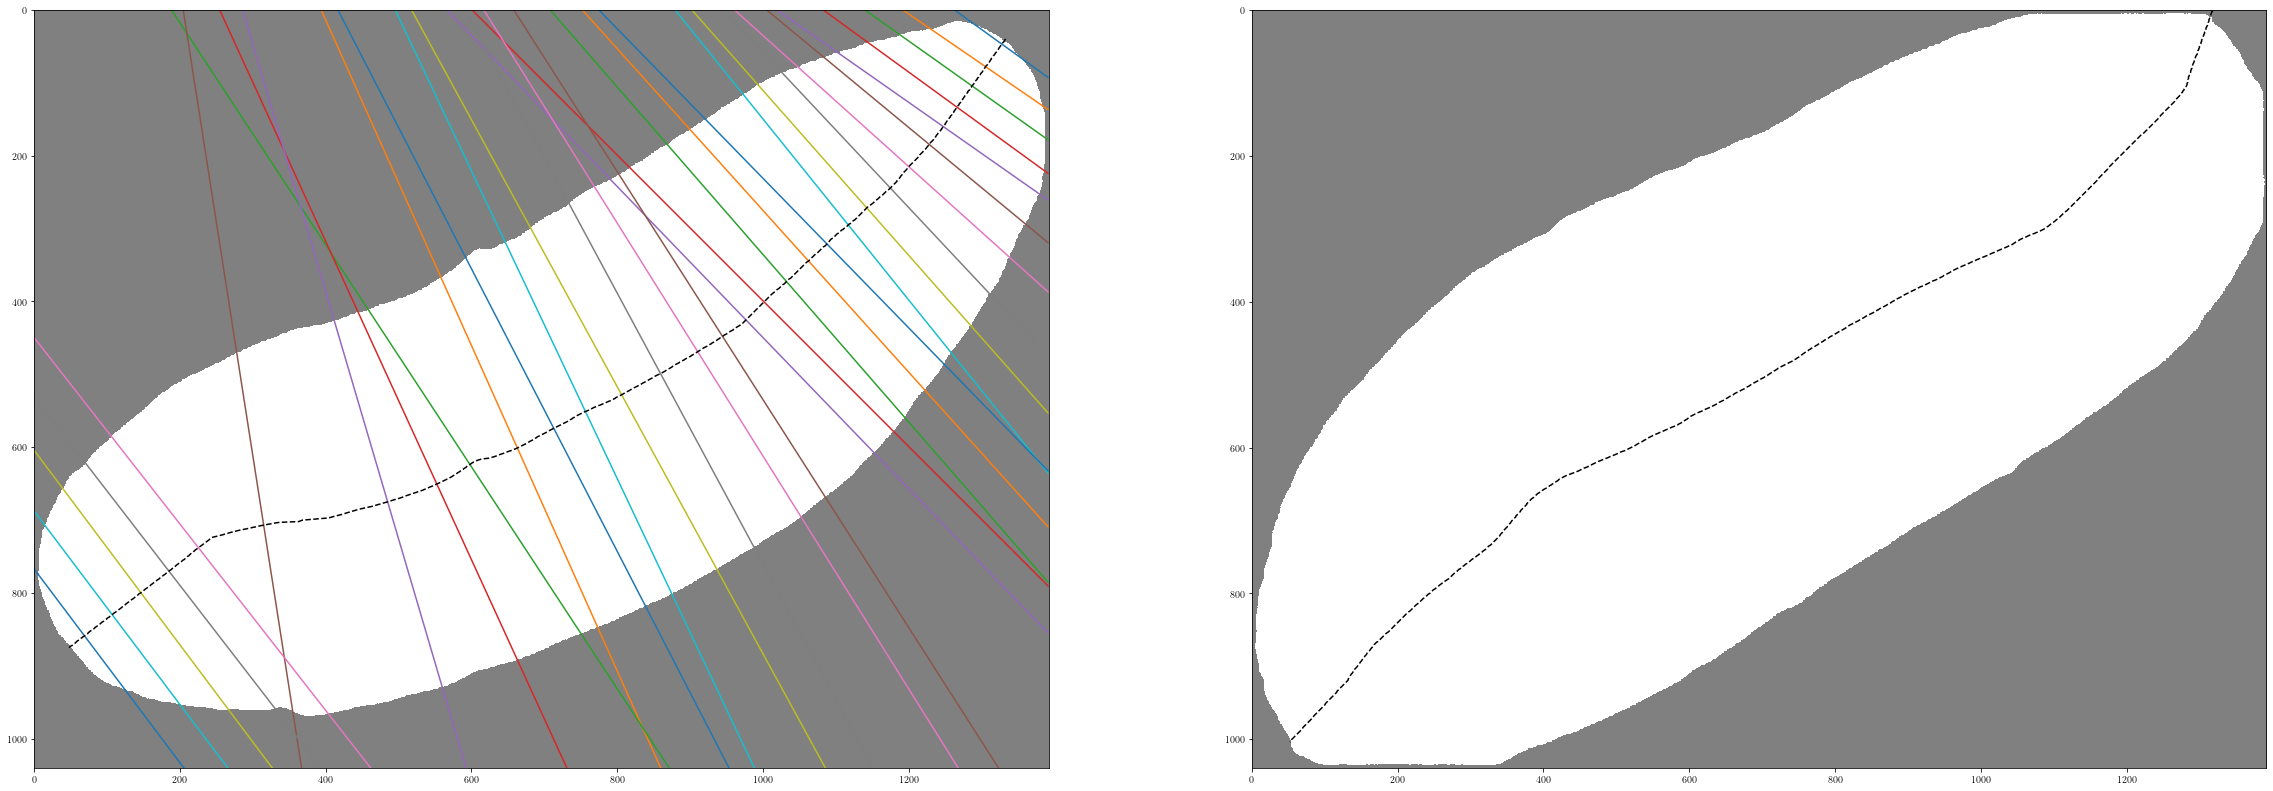

In [45]:
fig,axs=plt.subplots(1,2,figsize=(40,20))

wrm1 = dnsd1# + gh1*3 + cl1*2
wrm2 = dnsd2# + gh2*3 + cl2*2

cmap = colors.ListedColormap(['gray','white','blue','green','black'])
bounds=[0,1,2,3,4,5]
norm = colors.BoundaryNorm(bounds, cmap.N)

# tell imshow about color map so that only set colors are used
# img = plt.imshow(zvals, interpolation='nearest', origin='lower',
#                     cmap=cmap, norm=norm)

axs[0].imshow(wrm1, interpolation='nearest',cmap=cmap, norm=norm)
axs[1].imshow(wrm2, interpolation='nearest',cmap=cmap, norm=norm)

#axs[0].imshow(distimg1,vmin=0.01,vmax=400)
axs[0].plot(clidxs1[:,1],clidxs1[:,0],'k--',zorder=3)
#axs[0].plot(ghidxs1[:,1],ghidxs1[:,0],'b',zorder=2)
xs = np.arange(wrm1.shape[1])
for i in range(0,len(clPerps1),20):
    axs[0].plot(xs,clPerps1[i](xs))
axs[0].set_ylim(wrm1.shape[0],0)
axs[0].set_xlim(0,wrm1.shape[1])

#axs[1].imshow(distimg2,vmin=0.01,vmax=400)
axs[1].plot(clidxs2[:,1],clidxs2[:,0],'k--',zorder=2)
#axs[1].plot(ghidxs2[:,1],ghidxs2[:,0],'b',zorder=2)

#plt.savefig('{0}/bmp_ii_ml_axes_csecn_avg_{1}.jpg'.format(plotdir,npad*2+1), bbox_inches="tight")

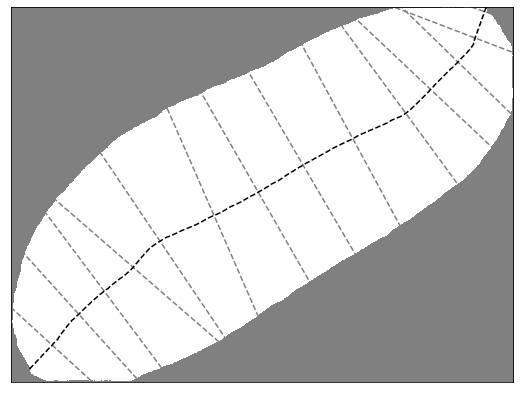

In [46]:
fig,axs=plt.subplots(1,1,figsize=(9,7))

wrm2 = dnsd2 # + gh2*3 + cl2*2

cmap   = colors.ListedColormap(['gray','white','blue','green','black'])
bounds =[0,1,2,3,4,5]
norm   = colors.BoundaryNorm(bounds, cmap.N)

# tell imshow about color map so that only set colors are used
# img = plt.imshow(zvals, interpolation='nearest', origin='lower',
#                     cmap=cmap, norm=norm)

axs.imshow(wrm2, interpolation='nearest',cmap=cmap, norm=norm)
axs.plot(clidxs2[:,1],clidxs2[:,0],'k--',zorder=3)

xs = np.arange(wrm2.shape[1])
for i in range(0,len(clPerps2),50):
    axs.plot(xs,clPerps2[i](xs),color='gray',linestyle='dashed')
axs.set_ylim(wrm2.shape[0],0)
axs.set_xlim(0,wrm2.shape[1])

axs.set_xticks([])
axs.set_yticks([])

plt.savefig('{0}/dapi_midline_perps_14.jpg'.format(plotdir), bbox_inches="tight")

#axs[1].plot(clidxs2[:,1],clidxs2[:,0],'k--',zorder=2)

In [48]:
pointCloud1 = np.array(eng.eval("xpM1.detector.pointCloud.points"),dtype='int') - 1
pointCloud2 = np.array(eng.eval("xpM2.detector.pointCloud.points"),dtype='int') - 1

In [49]:
# center of mass of surface

cm1, moiv1, moimag1 = cm_and_moi(mask1, sumdI1, surfMat1)
cm2, moiv2, moimag2 = cm_and_moi(mask2, sumdI2, surfMat2)


In [50]:
# fig,axs=plt.subplots(1,1,figsize=(3,3))
# axs.imshow(mask*surfMat)
# axs.plot(cm[0],cm[1],'ko',markersize=10,)
# axs.arrow(cm[0], cm[1], lens[0]*v1[0], lens[0]*v1[1], color='red',linewidth=2)
# axs.arrow(cm[0], cm[1], lens[1]*v2[0], lens[1]*v2[1], color='yellow',linewidth=2)
# axs.arrow(cm[0], cm[1], lens[2]*v3[0], lens[2]*v3[1], color='cyan',linewidth=2)

In [51]:
# surface fitting... (finds the metric basically)
fitOptions = {'smoothing': 500., 
              'gridSize': matlab.uint8([50,50])
             };

eng.setFitOptions(xp1,fitOptions,nargout=0);
eng.fitSurface(xp1,nargout=0);
eng.generateSOI(xp1,nargout=0);

eng.setFitOptions(xp2,fitOptions,nargout=0);
eng.fitSurface(xp2,nargout=0);
eng.generateSOI(xp2,nargout=0);

In [52]:
# run this because it initializes stuff
l0 = eng.eval("xpM1.SOI.properLength(1,[788 52; 800 55],'xy')");
l1 = eng.eval("xpM2.SOI.properLength(1,[750 52; 850 55],'xy')");

In [53]:
#getdist(np.array([[750,52],[850,55]]),np.array([[0,0],[-100,-3]]),met2)

In [54]:
chartName='xy'
domName = 'xy_index'
gti = 1
#stepSize = np.array(eng.eval("xpM1.SOI.atlas(1).getChart('xy').image.stepSize"))

eng.evalc("metric1=xpM1.SOI.g(1).getPatch('{0}').getTransform('{1}').apply();".format(domName,chartName))
eng.evalc("metric2=xpM2.SOI.g(1).getPatch('{0}').getTransform('{1}').apply();".format(domName,chartName))

'getTranform returning defining rep\n'

In [55]:
met1 = np.array([[np.array(eng.eval("metric1{1,1}")), np.array(eng.eval("metric1{1,2}"))],
        [np.array(eng.eval("metric1{2,1}")), np.array(eng.eval("metric1{2,2}"))]])

met2 = np.array([[np.array(eng.eval("metric2{1,1}")), np.array(eng.eval("metric2{1,2}"))],
        [np.array(eng.eval("metric2{2,1}")), np.array(eng.eval("metric2{2,2}"))]])

In [58]:
clidxs1  = np.vstack(np.where(cl1>0)).T
pc1      = np.flip(pointCloud1[:,0:2],axis=1)

cldists1, cldistIdxs1 = surfaceDists(clidxs1, pc1, met1)

In [59]:
clidxs2  = np.vstack(np.where(cl2>0)).T
pc2      = np.flip(pointCloud2[:,0:2],axis=1)

cldists2, cldistIdxs2 = surfaceDists(clidxs2, pc2, met2)

In [60]:
distimg1 = 1/np.zeros_like(mask1)
distimg1[pointCloud1[:,1],pointCloud1[:,0]]=cldists1

distimg2 = 1/np.zeros_like(mask2)
distimg2[pointCloud2[:,1],pointCloud2[:,0]]=cldists2

/Users/simonfreedman/opt/anaconda3/envs/img/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/simonfreedman/opt/anaconda3/envs/img/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


In [61]:
rowmap1 = get_rowmap(cldistIdxs1)
rowmap2 = get_rowmap(cldistIdxs2)

In [62]:
xs = np.arange(wrm1.shape[1])
ysA = [np.array(np.around(clperp(xs)),dtype='int') for clperp in clPerps1]
perpPts1 = [np.array([ys,xs]).T for ys in ysA]

pc1set = set(tuple(x) for x in pc1)
surfPerps1 = [np.array([x for x in set(tuple(x) for x in perppt) & pc1set]) for perppt in perpPts1]

In [63]:
xs = np.arange(wrm2.shape[1])
ysA = [np.array(np.around(clperp(xs)),dtype='int') for clperp in clPerps2]
perpPts2 = [np.array([ys,xs]).T for ys in ysA]

pcset = set(tuple(x) for x in pc2)
surfPerps2 = [np.array([x for x in set(tuple(x) for x in perppt) & pcset]) for perppt in perpPts2]


In [64]:
surfPerpsXZ1 = [np.array([surfPerps1[i][:,1],
                         surfMat1[surfPerps1[i][:,0],surfPerps1[i][:,1]]/(zdim/xdim)], 
                         dtype='int').T
                for i in range(len(surfPerps1))]
surfPerpsXZ2 = [np.array([surfPerps2[i][:,1],
                         surfMat2[surfPerps2[i][:,0],surfPerps2[i][:,1]]/(zdim/xdim)], 
                         dtype='int').T
                for i in range(len(surfPerps2))]


(0, 1392)

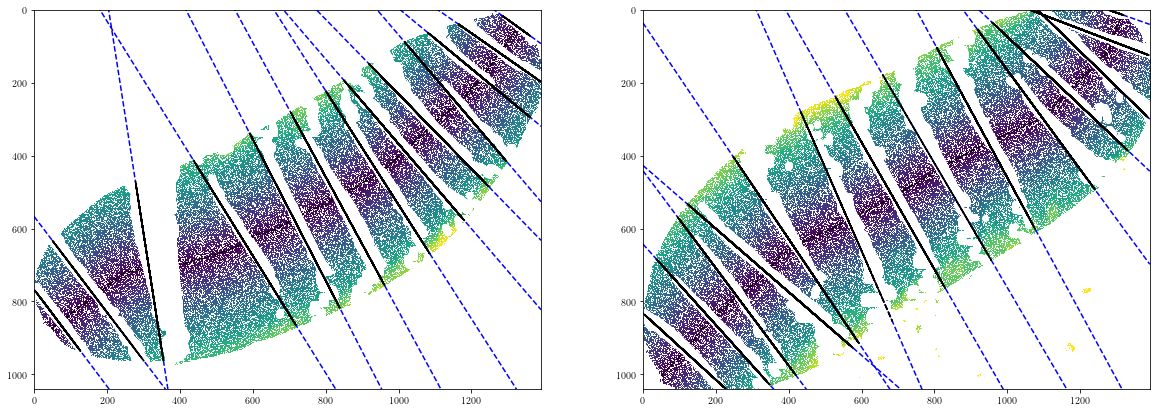

In [66]:
fig,axs=plt.subplots(1,2, figsize=(20,10))
axs[0].imshow(distimg1,vmin=0.01,vmax=400)
axs[0].plot(clidxs1[:,1],clidxs1[:,0],'k--',zorder=2)

for j in range(0,len(rowmap1),50):
    for cs in range(j,j+5):
        axs[0].plot(pc1[rowmap1[cs],1],pc1[rowmap1[cs],0],'wo',zorder=2)

# xs = np.arange(wrm1.shape[1])

for i in range(0,len(surfPerps1),50):
    axs[0].plot(xs,clPerps1[i](xs),'b--') 
    axs[0].plot(surfPerps1[i][:,1],surfPerps1[i][:,0],'k--') 
    
axs[0].set_ylim(distimg1.shape[0],0)
axs[0].set_xlim(0,distimg1.shape[1])

axs[1].imshow(distimg2,vmin=0.01,vmax=400)
axs[1].plot(clidxs2[:,1],clidxs2[:,0],'k--',zorder=2)
for j in range(0,len(rowmap2)-5,50):
    for cs in range(j,j+5):
        axs[1].plot(pc2[rowmap2[cs],1],pc2[rowmap2[cs],0],'wo',zorder=2)

xs = np.arange(wrm2.shape[1])
for i in range(0,len(surfPerps2),50):
    axs[1].plot(xs,clPerps2[i](xs),'b--') 
    axs[1].plot(surfPerps2[i][:,1],surfPerps2[i][:,0],'k--') 
    
axs[1].set_ylim(distimg2.shape[0],0)
axs[1].set_xlim(0,distimg2.shape[1])


NameError: name 'avgpbB2' is not defined

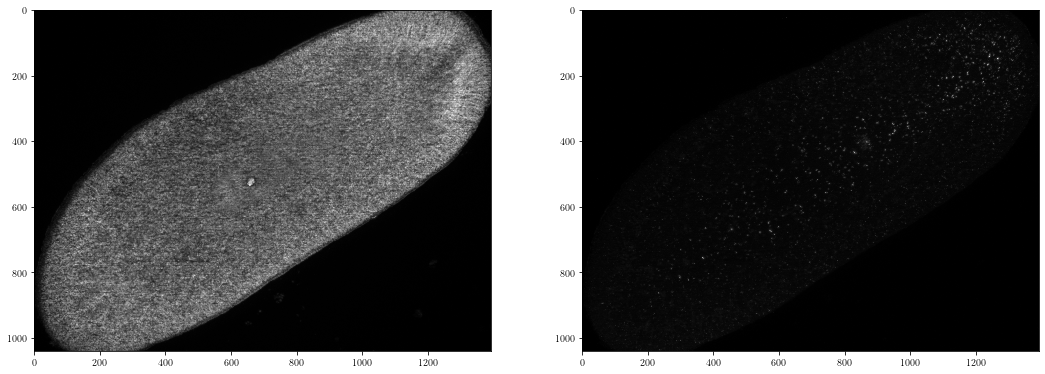

In [67]:
fig,axs=plt.subplots(1,2,figsize=(18,14))
axs[0].imshow(maxproj2d,cmap='binary_r')
axs[1].imshow(maxproj2b,cmap='binary_r')
cmap = plt.get_cmap('viridis')
#cmap.set_under('whitesmoke')  # Color for values less than vmin
cmap.set_bad(color='white')

#cmap.set_over('whitesmoke')  # Color for values less than vmin

labs = ['distance from centerline ($\mu$m)', '[BMP] along surface']
dats = [distimg2, avgpbB2]
vmins = [0.01,50]
vmaxs = [389,350]
for i in range(2):
    im1      = axs[i].imshow(dats[i], vmin = vmins[i], vmax = vmaxs[i], cmap=cmap) #vmax=np.nanquantile(dats[i],0.99))
    divider  = make_axes_locatable(axs[i])
    cax2     = divider.append_axes("top", size="5%", pad=0.05)
    cbar     = fig.colorbar(im1, cax=cax2, orientation='horizontal')
    cbar.set_label(labs[i],rotation=0, labelpad=10, fontsize=18)
    cax2.xaxis.set_label_position('top')
    cax2.xaxis.set_ticks_position('top')
    cbar.ax.tick_params(labelsize=18)
    
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.subplots_adjust(wspace=0.02)

#plt.savefig('{0}/dist_bmppb_14.jpg'.format(plotdir), bbox_inches="tight")

In [70]:
npad = 25

perpPts = perpPts2
zstk    = im2d #im2bbs
surfPts = surfPerpsXZ2

colns  = [npad,100,200,300,400,500,len(perpPts)-npad-1]
css = [np.mean(np.array([get_ml_cs(perpPts, i, zstk) #im1bRBimg) 
                         for i in range(coln-npad, coln+npad+1)]), axis=0) 
       for coln in colns]

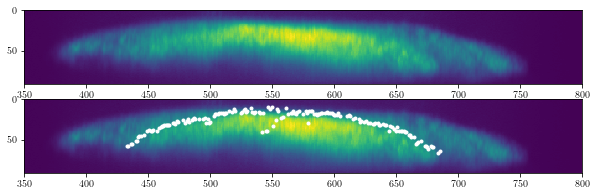

In [71]:
fig,axs=plt.subplots(2,1,figsize=(10,3))
axs[0].imshow(css[4], aspect = 'auto')#,vmin=25,vmax=250)
axs[1].imshow(css[4], aspect = 'auto')#,vmin=25,vmax=250)
axs[1].plot(surfPts[colns[4]][:,0],surfPts[colns[4]][:,1],'wo', ms=3)

for i in range(2):
    axs[i].set_xlim(350,800)
#axs[-1].set_xticks(range(0,1392,200))
#axs[-1].set_xticklabels(range(0,1392,200))

(Text(0.5, 1.0, 'II: BMP'),)

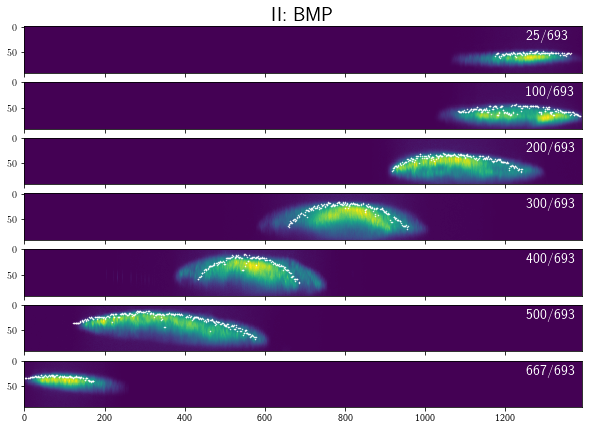

In [72]:
fig,axs=plt.subplots(len(colns),1,figsize=(10,7))
for i in range(len(colns)):
    axs[i].imshow(css[i], aspect = 'auto')#,vmin=25,vmax=250)
    axs[i].text(x=0.9,y=0.7,s='{0}/{1}'.format(colns[i],len(perpPts)),
                color='white', fontsize=14,transform=axs[i].transAxes)
    axs[i].set_xticklabels([])
    axs[i].plot(surfPts[colns[i]][:,0],surfPts[colns[i]][:,1],'w.', ms=1)
axs[-1].set_xticks(range(0,1392,200))
axs[-1].set_xticklabels(range(0,1392,200))
                     
axs[0].set_title('II: BMP', fontsize=20),
#plt.savefig('{0}/bmp_ii_ml_axes_csecn_avg_{1}.jpg'.format(plotdir,npad*2+1), bbox_inches="tight")

In [74]:
nz = 31
nr,nc = mask1.shape
pbsD1, pbsB1, pbsBbs1 = pbsDB('xpM1', nz, nr, nc)

In [75]:
nr,nc = mask2.shape
pbsD2, pbsB2, pbsBbs2 = pbsDB('xpM2', nz, nr, nc)

In [76]:
avgpbD1   = np.mean(pbsD1,axis=0)
avgpbB1   = np.mean(pbsB1,axis=0)
avgpbBbs1 = np.mean(pbsBbs1,axis=0)

avgpbD2   = np.mean(pbsD2,axis=0)
avgpbB2   = np.mean(pbsB2,axis=0)
avgpbBbs2 = np.mean(pbsBbs2,axis=0)

In [77]:
pbsD1.shape

(31, 1040, 1392)

In [69]:
imOut = np.array([pbsD1,pbsB1,pbsBbs1]).transpose((1,2,3,0))
sampname = 'dorsal_7' #'w2_dorsal_14_'
io.imsave('{0}/{1}_combinedDAPI_BMP_BMPbs_surface_pb_{2}.tif'.format(datdir,sampname,nz),imOut)

imOut = np.array([pbsD2,pbsB2,pbsBbs2]).transpose((1,2,3,0))
sampname = 'w2_dorsal_14'
io.imsave('{0}/{1}_combinedDAPI_BMP_BMPbs_surface_pb_{2}.tif'.format(datdir,sampname,nz),imOut)

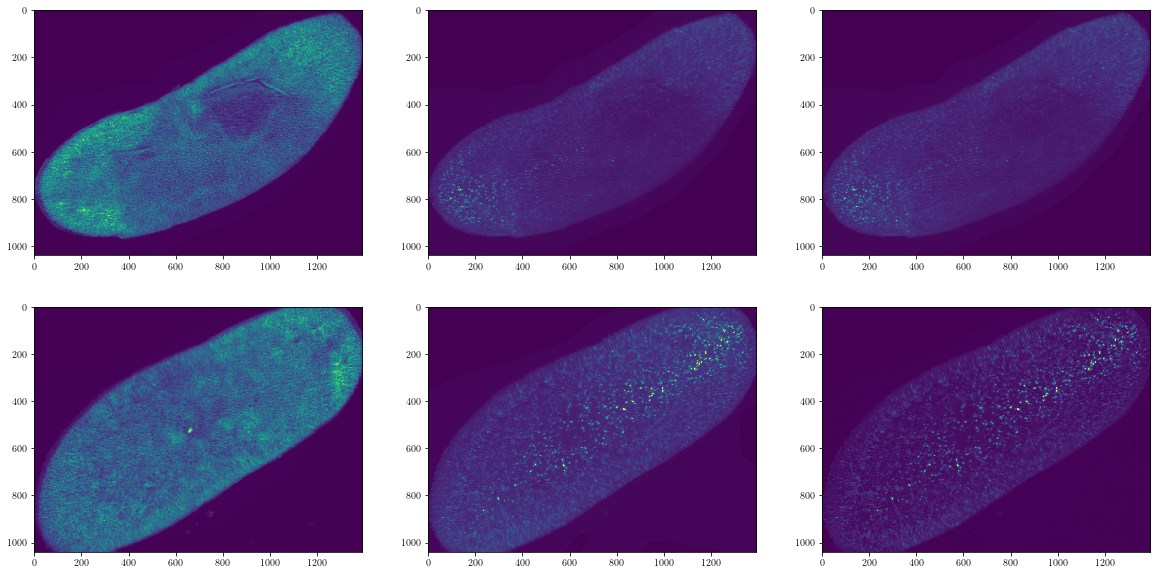

In [211]:
fig,axs=plt.subplots(2,3,figsize=(20,10))
axs[0,0].imshow(avgpbD1)
axs[0,1].imshow(avgpbB1,vmax=1000)
axs[0,2].imshow(avgpbB1,vmax=1000)

axs[1,0].imshow(avgpbD2)
axs[1,1].imshow(avgpbB2,vmax=1000)
axs[1,2].imshow(avgpbBbs2,vmax=1000)

# for i in range(0,len(surfPerps2),50):
#     axs[1,0].plot(xs,clPerps2[i](xs),'b--') 
#     axs[1,0].plot(surfPerps2[i][:,1],surfPerps2[i][:,0],'k--') 
    
# axs[1,0].set_ylim(distimg2.shape[0],0)
# axs[1,0].set_xlim(0,distimg2.shape[1])

In [258]:
# fig,axs=plt.subplots()
# axs.imshow(avgpbB1*mask1/avgpbD1,vmax=1)

In [ ]:
# cldists1, cldistIdxs1

In [295]:
#len(surfPerps1), len(clidxs1[5:-5])

(608, 608)

In [70]:
surfPerps1s = [x[x[:,0].argsort()] for x in surfPerps1]
surfPerps2s = [x[x[:,0].argsort()] for x in surfPerps2]

In [71]:
surfPerp1dists = [surfaceDists(np.array([clidxs1[i+5]]),surfPerps1s[i],met1)[0] for i in range(len(surfPerps1s))]
surfPerp2dists = [surfaceDists(np.array([clidxs2[i+5]]),surfPerps2s[i],met2)[0] for i in range(len(surfPerps2s))]


In [72]:
argmins1 = list(map(np.argmin,surfPerp1dists))
argmins2 = list(map(np.argmin,surfPerp2dists))

surfPerpDsgn1 = [np.hstack([-1*surfPerp1dists[i][:argmins1[i]], surfPerp1dists[i][argmins1[i]:]]) 
                 for i in range(len(argmins1))]
surfPerpDsgn2 = [np.hstack([-1*surfPerp2dists[i][:argmins2[i]], surfPerp2dists[i][argmins2[i]:]]) 
                 for i in range(len(argmins2))]

In [73]:
cldists1 = np.cumsum([0] + [surfaceDists(clidxs1[[i]],clidxs1[[i+1]],met1)[0][0] for i in range(len(clidxs1)-1)])
cldists2 = np.cumsum([0] + [surfaceDists(clidxs2[[i]],clidxs2[[i+1]],met2)[0][0] for i in range(len(clidxs2)-1)])

In [74]:
sampname = 'dorsal_7' #'w2_dorsal_14_'
np.savez_compressed('{0}/{1}_cldists'.format(datdir,sampname), a=cldists1)
np.savez_compressed('{0}/{1}_surfPerpDists'.format(datdir,sampname), a=surfPerpDsgn1)

sampname = 'w2_dorsal_14'
np.savez_compressed('{0}/{1}_cldists'.format(datdir,sampname), a=cldists2)
np.savez_compressed('{0}/{1}_surfPerpDists'.format(datdir,sampname), a=surfPerpDsgn2)


In [388]:
# (i*np.ones((nz,len(surfPerpDsgn2[i])))).shape,np.outer(np.ones(nz),surfPerpDsgn2[i]).shape,pbsBbs2[:,surfPerps2s[i][:,0], surfPerps2s[i][:,1]].shape

In [202]:
bbsMat1[0].shape,len(surfPerps1s[0]), len(cldists1)

((54, 31, 9), 54, 618)

In [189]:
zi = 7 #int((nz+1)/2)#0
zf = 22 #zi+10 #nz #int((nz+1)/2)

bbsMat1 = [np.array([np.outer(np.ones(nz),surfPerpDsgn1[i]),
                     cldists1[i]*np.ones((nz,len(surfPerpDsgn1[i]))),
                     pbsD1[:,surfPerps1s[i][:,0], surfPerps1s[i][:,1]],
                     pbsB1[:,surfPerps1s[i][:,0], surfPerps1s[i][:,1]],
                     pbsBbs1[:,surfPerps1s[i][:,0], surfPerps1s[i][:,1]],
                     divz(pbsB1[:,surfPerps1s[i][:,0], surfPerps1s[i][:,1]],
                          pbsD1[:,surfPerps1s[i][:,0], surfPerps1s[i][:,1]]),
                     divz(pbsBbs1[:,surfPerps1s[i][:,0], surfPerps1s[i][:,1]],
                          pbsD1[:,surfPerps1s[i][:,0], surfPerps1s[i][:,1]]),
                     divz(
                         np.log(pbsB1[:,surfPerps1s[i][:,0], surfPerps1s[i][:,1]]),
                         np.log(pbsD1[:,surfPerps1s[i][:,0], surfPerps1s[i][:,1]])),
                     np.log(
                         divz(pbsB1[:,surfPerps1s[i][:,0], surfPerps1s[i][:,1]],
                              pbsD1[:,surfPerps1s[i][:,0], surfPerps1s[i][:,1]]))
                     ]).transpose((2,1,0)) 
           for i in range(len(surfPerps1s))
          ]
bbsDps1 = np.vstack(bbsMat1)[:,zi:zf].reshape(-1,bbsMat1[0].shape[-1])


bbsMat2 = [np.array([np.outer(np.ones(nz),surfPerpDsgn2[i]),
                     cldists2[i]*np.ones((nz,len(surfPerpDsgn2[i]))),
                     pbsD2[:,surfPerps2s[i][:,0], surfPerps2s[i][:,1]],
                     pbsB2[:,surfPerps2s[i][:,0], surfPerps2s[i][:,1]],
                     pbsBbs2[:,surfPerps2s[i][:,0], surfPerps2s[i][:,1]],
                     divz(pbsB2[:,surfPerps2s[i][:,0], surfPerps2s[i][:,1]],
                          pbsD2[:,surfPerps2s[i][:,0], surfPerps2s[i][:,1]]),
                     divz(pbsBbs2[:,surfPerps2s[i][:,0], surfPerps2s[i][:,1]],
                          pbsD2[:,surfPerps2s[i][:,0], surfPerps2s[i][:,1]]),
                     divz(
                         np.log(pbsB2[:,surfPerps2s[i][:,0], surfPerps2s[i][:,1]]),
                         np.log(pbsD2[:,surfPerps2s[i][:,0], surfPerps2s[i][:,1]])),
                     np.log(
                         divz(pbsB2[:,surfPerps2s[i][:,0], surfPerps2s[i][:,1]],
                              pbsD2[:,surfPerps2s[i][:,0], surfPerps2s[i][:,1]]))
                    ]).transpose((2,1,0)) 
           for i in range(len(surfPerps2s))
          ]
bbsDps2 = np.vstack(bbsMat2)[:,zi:zf].reshape(-1,bbsMat2[0].shape[-1])


/anaconda3/envs/img/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/anaconda3/envs/img/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/anaconda3/envs/img/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log


In [497]:
avgdps1 = np.vstack([np.vstack([xs,
                                y*np.ones_like(xs),
                                avgpbD1[xidxs[:,0],xidxs[:,1]],
                                avgpbB1[xidxs[:,0],xidxs[:,1]],
                                #avgpbBbs1[xidxs[:,0],xidxs[:,1]],
                                divz(avgpbB1[xidxs[:,0],xidxs[:,1]],avgpbD1[xidxs[:,0],xidxs[:,1]])
                               ]).T 
                        for xs,xidxs,y in zip(surfPerpDsgn1, surfPerps1, cldists1)])

avgdps2 = np.vstack([np.vstack([xs,
                                y*np.ones_like(xs),
                                avgpbD2[xidxs[:,0],xidxs[:,1]],
                                avgpbB2[xidxs[:,0],xidxs[:,1]],
                               # avgpbBbs2[xidxs[:,0],xidxs[:,1]],
                                divz(avgpbB2[xidxs[:,0],xidxs[:,1]],avgpbD2[xidxs[:,0],xidxs[:,1]])
                               ]).T 
                        for xs,xidxs,y in zip(surfPerpDsgn2, surfPerps2, cldists2)])


In [317]:
avgpbB1.shape,np.max(surfPerps1[0][:,1])

((1040, 1392), 1363)

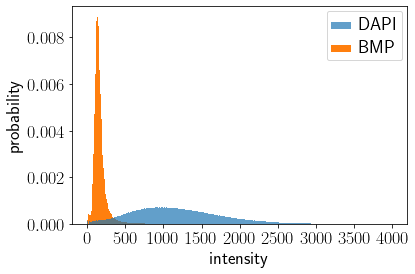

In [243]:
fig,axs=plt.subplots()
sampname = 'w2_dorsal_14'

axs.hist(bbsDps2[:,2],bins=np.arange(0,4000,10), zorder=2, density=True,alpha=0.7, label='DAPI')
axs.hist(bbsDps2[:,3],bins=np.arange(0,800,10),zorder=1, density=True, label='BMP')
#axs.set_yscale('log')
axs.set_xlabel('intensity')
axs.set_ylabel('probability')
axs.legend(loc=(0.7,0.7))
mf.set_axs_fontsize(axs, 18, True)
plt.savefig('{0}/bmp_dapi_intensity_hists_lin_{1}.jpg'.format(plotdir,sampname), bbox_inches="tight")

In [501]:
bmpMin    = 100
dapiMin   = 500
idxs      = np.where((bbsDps2[:,2]>dapiMin) & (bbsDps2[:,3]>bmpMin))
bbsDps2th = bbsDps2[idxs]

In [502]:
len(bbsDps2), len(bbsDps2th)

(2199060, 1777620)

In [503]:
# binnninninnninning

xmin = -500 #bbsDps2[:,0].min()
xmax = 500 #bbsDps2[:,0].max()
ymin = 0
ymax = 1750 #bbsDps2[:,1].max()

bsz = 25
binsx = np.arange(xmin, xmax+bsz, bsz)
binsy = np.arange(ymin, ymax+bsz, bsz)

bxdig1 = np.digitize(bbsDps1[:,0], binsx)-1
bydig1 = np.digitize(bbsDps1[:,1], binsy)-1

bxidxs1  = [np.where(bxdig1==i) for i in range(1,len(binsx))]
bxyidxs1 = [[np.where(bydig1[bxidxs1[i]]==j) for j in range(1,len(binsy))] 
            for i in range(len(binsx)-1)]

bxdig2 = np.digitize(bbsDps2th[:,0], binsx)-1
bydig2 = np.digitize(bbsDps2th[:,1], binsy)-1

bxidxs2  = [np.where(bxdig2==i) for i in range(1,len(binsx))]
bxyidxs2 = [[np.where(bydig2[bxidxs2[i]]==j) for j in range(1,len(binsy))] 
            for i in range(len(binsx)-1)]



In [504]:
avgConcs1 = [np.array([[meanor0(bbsDps1[idxsij,k]) for idxsij in idxsi] for idxsi in bxyidxs1])
             for k in range(2,8)
            ]
avgConcs2 = [np.array([[meanor0(bbsDps2th[idxsij,k]) for idxsij in idxsi] for idxsi in bxyidxs2])
             for k in range(2,8)
            ]

maxConcs2 = [np.array([[clean_nanmax(bbsDps2th[idxsij,k]) for idxsij in idxsi] for idxsi in bxyidxs2])
             for k in range(2,8)
            ]



/anaconda3/envs/img/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


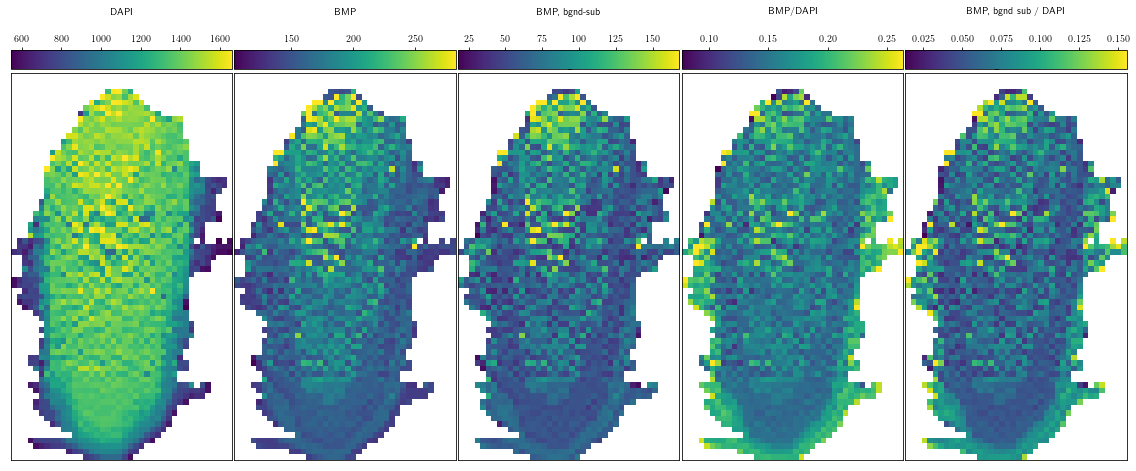

In [250]:
fig,axs=plt.subplots(1,5,figsize=(20,40))

labs = ['DAPI', 'BMP', 'BMP, bgnd-sub', 'BMP/DAPI', 'BMP, bgnd sub / DAPI']

for i in range(5):
    im1 = axs[i].imshow(avgConcs2[i].T,    origin='lower', vmax=np.nanquantile(avgConcs2[i],0.99))
    divider = make_axes_locatable(axs[i])
    cax2     = divider.append_axes("top", size="5%", pad=0.05)
    cbar = fig.colorbar(im1, cax=cax2, orientation='horizontal')
    cbar.set_label(labs[i],rotation=0, labelpad=20)
    cax2.xaxis.set_label_position('top')
    cax2.xaxis.set_ticks_position('top')
    
    #axs[i].imshow(maxConcs2[i].T,    origin='lower', vmax=np.nanquantile(maxConcs2[i],0.9999))



#axs[4].imshow(blnxyidxs2mu.T, origin='lower', vmax=np.nanquantile(blnxyidxs2mu,0.9))#,vmax=250)#,vmin=0,vmax=0.4,origin='lower')
#axs[4].imshow(x.T, origin='lower', vmax=np.nanquantile(x,0.9))#,vmax=250)#,vmin=0,vmax=0.4,origin='lower')


for i in range(5):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(labs[i])
plt.subplots_adjust(wspace=0.01)



In [505]:
bmpMin    = 100
dapiMin   = 500

idxs      = np.where((avgdps1[:,2]>dapiMin) & (avgdps1[:,3]>bmpMin))
avgdps1th = avgdps1[idxs]

idxs      = np.where((avgdps2[:,2]>dapiMin) & (avgdps2[:,3]>bmpMin))
avgdps2th = avgdps2[idxs]

In [506]:

bxdig1 = np.digitize(avgdps1th[:,0], binsx)-1
bydig1 = np.digitize(avgdps1th[:,1], binsy)-1

bxidxs1  = [np.where(bxdig1==i) for i in range(1,len(binsx))]
bxyidxs1 = [[np.where(bydig1[bxidxs1[i]]==j) for j in range(1,len(binsy))] 
            for i in range(len(binsx)-1)]

bxdig2 = np.digitize(avgdps2th[:,0], binsx)-1
bydig2 = np.digitize(avgdps2th[:,1], binsy)-1

bxidxs2  = [np.where(bxdig2==i) for i in range(1,len(binsx))]
bxyidxs2 = [[np.where(bydig2[bxidxs2[i]]==j) for j in range(1,len(binsy))] 
            for i in range(len(binsx)-1)]



In [507]:
avgConcs1 = [np.array([[meanor0(avgdps1th[idxsij,k]) for idxsij in idxsi] for idxsi in bxyidxs1])
             for k in range(2,5)
            ]
avgConcs2 = [np.array([[meanor0(avgdps2th[idxsij,k]) for idxsij in idxsi] for idxsi in bxyidxs2])
             for k in range(2,5)
            ]

/anaconda3/envs/img/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


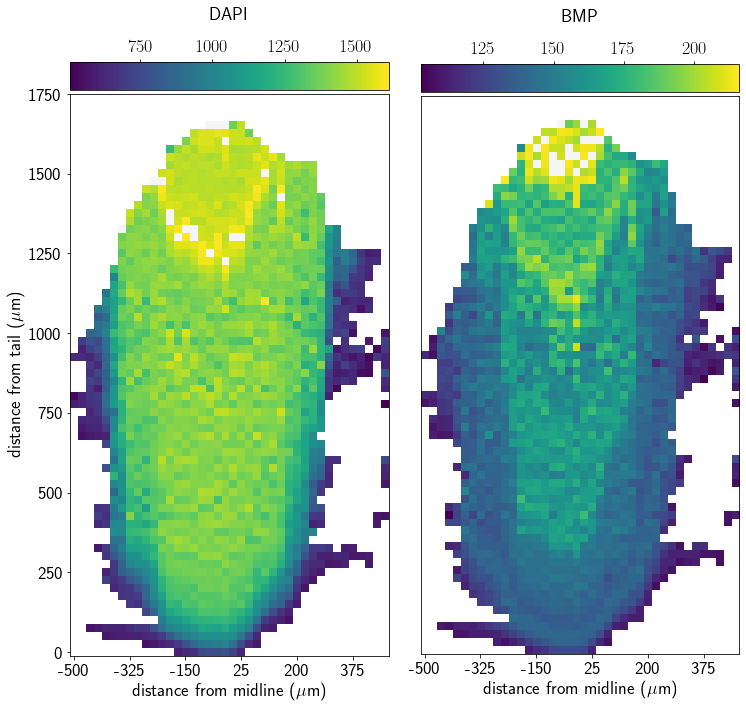

In [508]:
fig,axs=plt.subplots(1,2,figsize=(12,16))

labs = ['DAPI', 'BMP', 'BMP, bgnd-sub', 'BMP/DAPI', 'BMP, bgnd sub / DAPI']

for i in range(2):
    im1 = axs[i].imshow(avgConcs2[i].T,    origin='lower', vmax=np.nanquantile(avgConcs2[i],0.99))
    divider = make_axes_locatable(axs[i])
    cax2     = divider.append_axes("top", size="5%", pad=0.05)
    cbar = fig.colorbar(im1, cax=cax2, orientation='horizontal')
    cbar.set_label(labs[i],rotation=0, labelpad=20, fontsize=18)
    cax2.xaxis.set_label_position('top')
    cax2.xaxis.set_ticks_position('top')
    cbar.ax.tick_params(labelsize=18)
    axs[i].set_xticks(range(0,len(binsx),7))
    axs[i].set_xticklabels(binsx[::7])

    if i == 0:
        axs[i].set_yticks(range(0,len(binsy),10))
        axs[i].set_yticklabels(binsy[::10])
        axs[i].set_ylabel('distance from tail ($\mu$m)')
    else:
        axs[i].set_yticks([])
        
    mf.set_axs_fontsize(axs[i],18)
    
    axs[i].set_xlabel('distance from midline ($\mu$m)')
    
    #axs[i].imshow(maxConcs2[i].T,    origin='lower', vmax=np.nanquantile(maxConcs2[i],0.9999))



#axs[4].imshow(blnxyidxs2mu.T, origin='lower', vmax=np.nanquantile(blnxyidxs2mu,0.9))#,vmax=250)#,vmin=0,vmax=0.4,origin='lower')
#axs[4].imshow(x.T, origin='lower', vmax=np.nanquantile(x,0.9))#,vmax=250)#,vmin=0,vmax=0.4,origin='lower')


# for i in range(2):
#     #axs[i].set_xticks([])
#     #axs[i].set_yticks([])
#     axs[i].set_title(labs[i])
#axs[0].set_yticks()
plt.subplots_adjust(wspace=0.1)
plt.savefig('{0}/dapi_bmp_aligned_heatmaps.jpg'.format(plotdir), bbox_inches="tight")

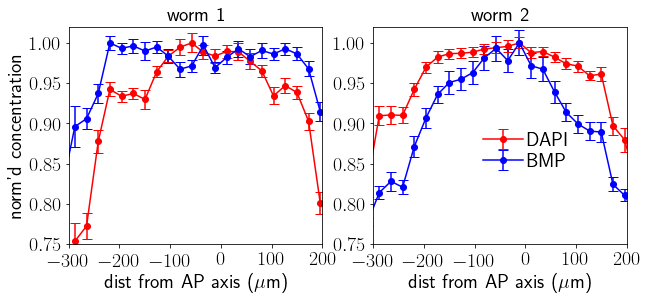

In [409]:
fig,axs=plt.subplots(1,2,figsize=(10,4))
xs = 0.5*xdim*(binsx[1:] + binsx[:-1])

#musd, errsd = mu_err(dxyidxs2mu)
#axs.errorbar(binsx[xi:xf]*xdim, musd, yerr=errsd,color='k',marker='o',capsize=5, label = 'worm 1')

#musb, errsb = mu_err(divz(bxyidxs2mu,dxyidxs2mu))
xi = 5
xf = 30
xs = xs[xi:xf]
yi = 10
yf = 70

musbbs1, errsbbs1 = mu_err(avgConcs1[0][xi:xf,yi:yf])
axs[0].errorbar(xs, musbbs1, yerr=errsbbs1,color='r',marker='o',capsize=5, label = 'DAPI')

musbbs2, errsbbs2 = mu_err(avgConcs1[1][xi:xf,yi:yf])
axs[0].errorbar(xs, musbbs2, yerr=errsbbs2,color='b',marker='o',capsize=5, label = 'BMP')


musbbs1, errsbbs1 = mu_err(avgConcs2[0][xi:xf,yi:yf])
axs[1].errorbar(xs, musbbs1, yerr=errsbbs1,color='r',marker='o',capsize=5, label = 'DAPI')

musbbs2, errsbbs2 = mu_err(avgConcs2[1][xi:xf,yi:yf])
axs[1].errorbar(xs, musbbs2, yerr=errsbbs2,color='b',marker='o',capsize=5, label = 'BMP')


axs[0].set_xlabel('dist from AP axis ($\mu$m)')
axs[1].set_xlabel('dist from AP axis ($\mu$m)')

axs[0].set_ylabel('norm\'d concentration')

axs[1].legend(loc=(0.4,0.3),fontsize=20,frameon=False,labelspacing=0.1,handletextpad=0.2)

axs[0].set_xlim(-300,200)
axs[1].set_xlim(-300,200)
axs[0].set_ylim(0.75,1.02)
axs[1].set_ylim(0.75,1.02)


axs[0].set_title('worm 1')
axs[1].set_title('worm 2')

mf.set_axs_fontsize(axs[0],20)
mf.set_axs_fontsize(axs[1],20)

#axs.set_ylim(0.5,0.95)
#plt.savefig('{0}/avg_bmp_dapi_vs_dist.jpg'.format(plotdir), bbox_inches="tight")

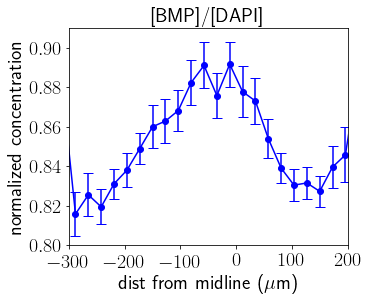

In [517]:
fig,axs=plt.subplots(1,1,figsize=(5,4))
xs = 0.5*xdim*(binsx[1:] + binsx[:-1])

#musd, errsd = mu_err(dxyidxs2mu)
#axs.errorbar(binsx[xi:xf]*xdim, musd, yerr=errsd,color='k',marker='o',capsize=5, label = 'worm 1')

#musb, errsb = mu_err(divz(bxyidxs2mu,dxyidxs2mu))
xi = 5
xf = 30
xs = xs[xi:xf]
yi = 10
yf = 70

#musbbs1, errsbbs1 = mu_err(avgConcs2[0][xi:xf,yi:yf])
#axs.errorbar(xs, musbbs1, yerr=errsbbs1,color='r',marker='o',capsize=5, label = 'DAPI')

musbbs2, errsbbs2 = mu_err(avgConcs2[2][xi:xf,yi:yf])
axs.errorbar(xs, musbbs2, yerr=errsbbs2,color='b',marker='o',capsize=5, label = 'BMP')


axs.set_xlabel('dist from midline ($\mu$m)')

axs.set_ylabel('normalized concentration')

#axs.legend(loc=(0.4,0.3),fontsize=20,frameon=False,labelspacing=0.1,handletextpad=0.2)

axs.set_xlim(-300,200)
axs.set_ylim(0.75,1.02)
axs.set_ylim(0.8,0.91)

axs.set_title('[BMP]/[DAPI]')
mf.set_axs_fontsize(axs,20)
plt.savefig('{0}/avg_bmp_over_dapi_vs_dist_14.jpg'.format(plotdir), bbox_inches="tight")